In [5]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from stockstats import StockDataFrame 
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data

import dataPreparation
files=['AAPL']#,'AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
prices=list()
for file in files:
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    
    priceData = get_price_data(param)
    stock = StockDataFrame.retype(priceData)
    price = pd.DataFrame(stock)
    string=['close_2_sma','close_4_sma','close_6_sma','close_8_sma','close_10_sma','close_12_sma','close_14_sma','close_16_sma','close_18_sma','pdi','mdi','dx','adx','adxr','cr','cr-ma1','cr-ma2','cr-ma3','boll','boll_ub','boll_lb','volume_-2_d','volume_-4_d','volume_-6_d','volume_-8_d','volume_-10_d','volume_-12_d','macd','macds','macdh','kdjk','kdjd','kdjj','tr','atr','wr_2','wr_10','wr_6','wr_8','wr_12','wr_14','close_-2_d','close_-4_d','close_-6_d','close_-8_d','close_-10_d','close_-12_d','close_-14_d','close_-16_d','rsi_2','rsi_4','rsi_6','rsi_8','rsi_10','rsi_12','rsi_14','rsi_16']

    stock.get(string)
    price = stock
    print(price)
    
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    
    prices.append(price)

/home/andrea/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


                         open      high       low     close    volume  \
2017-08-10 03:15:00  160.6547  160.7650  160.4000  160.5000    575878   
2017-08-10 03:30:00  160.5100  160.9200  160.5000  160.7200    675990   
2017-08-10 03:45:00  160.7267  160.9500  160.6500  160.8800    749837   
2017-08-10 04:00:00  160.8800  161.2100  160.8700  161.0600   2757480   
2017-08-10 21:30:00  159.9000  159.9400  159.8500  159.8800    398352   
2017-08-10 21:45:00  159.9300  160.0000  159.0400  159.1400   2037237   
2017-08-10 22:00:00  159.1600  159.2400  158.8100  159.0000   1818871   
2017-08-10 22:15:00  159.0000  159.1500  158.0500  158.5000   1969187   
2017-08-10 22:30:00  158.5000  159.0900  158.4450  159.0050   1215749   
2017-08-10 22:45:00  159.0100  159.1900  158.6500  159.1700    808211   
2017-08-10 23:00:00  159.1700  159.3000  159.0700  159.1105    705298   
2017-08-10 23:15:00  159.1136  159.1136  158.7820  158.8400    644671   
2017-08-10 23:30:00  158.8450  158.8750  158.1600  

In [6]:
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u

In [7]:
def buildModel(l,n,d):
    model = Sequential()  
    model.add(Dense(n, input_dim=111,activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/2), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/4), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='sigmoid')) 
    
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

    return model

def findMaxAcc(valacc,valloss):
	prevloss=valloss[0]
	for i in range(1,len(valloss)):
		if(valloss[i]>prevloss):
			return valacc[i-1]
	#print('Problems with find MaxAccuracy')
	return valacc[len(valacc)-1]
def findMaxAccStep(valacc,valloss):
	prevloss=valloss[0]
	for i in range(1,len(valloss)):
		if(valloss[i]>prevloss):
			return i-1
	#print('Problems with find MaxAccuracy')
	return len(valacc)-1

Working on... AAPL
window time  200


/home/andrea/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


working on d,u and l 0.5 64 0.05
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/an

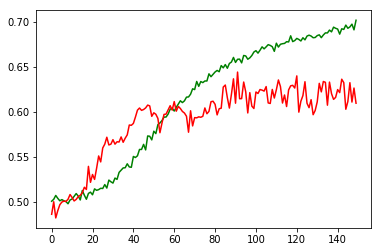

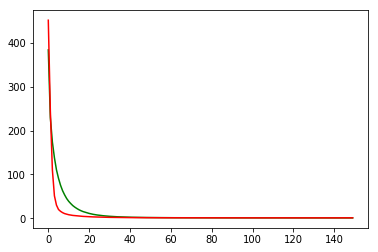

working on d,u and l 0.5 64 0.01
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/an

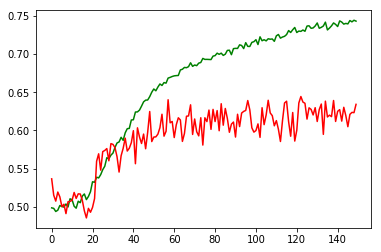

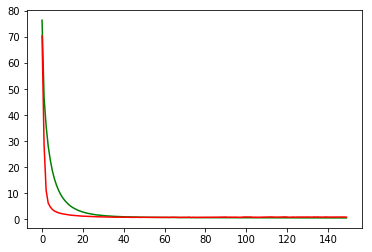

working on d,u and l 0.5 128 0.05
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/an

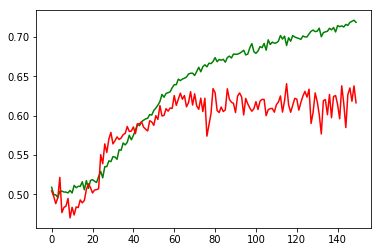

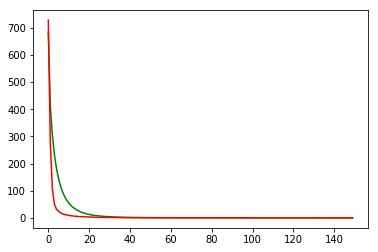

working on d,u and l 0.5 128 0.01
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/an

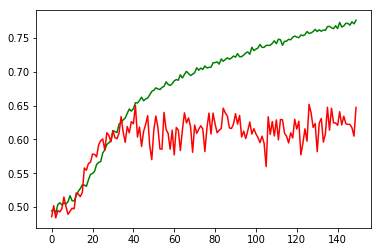

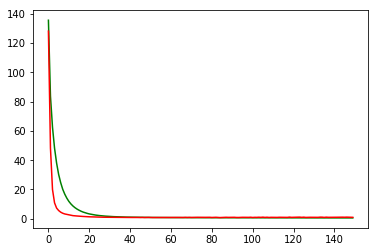

working on d,u and l 0.5 256 0.05
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/an

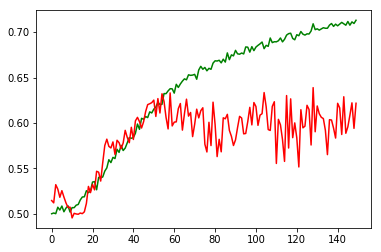

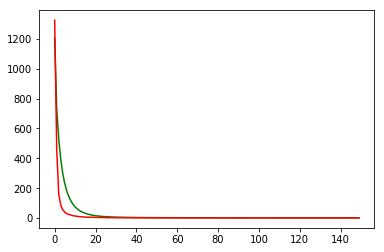

working on d,u and l 0.5 256 0.01
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/andrea/an

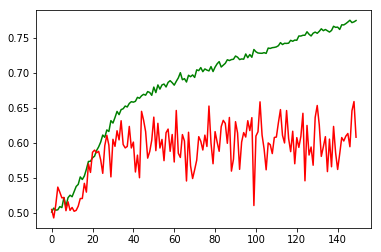

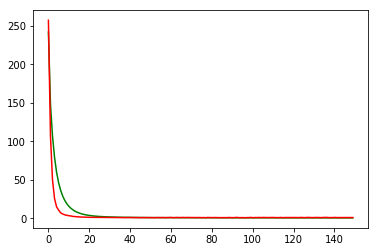

Test


TypeError: buildModel() missing 1 required positional argument: 'd'

In [8]:
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=0) 
for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    o+=1
    xtemp=price
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    xtemp=normalize(xtemp,axis=0,norm='max')
    #print(xtemp)
    accintime=[]
    trendwindowtime=[200]
    f1total=[]
    acctotal=[]
    auctotal=[]
    f1scoretotal=[]
    for t in trendwindowtime:
        #1
        print('===================================================================')
        print('===================================================================')
        print('===================================================================')
        print('window time ',t)
        print('===================================================================')
        print('===================================================================')
        print('===================================================================')
        print('===================================================================')
        print('===================================================================')
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        

        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            
            if(s==-1):
                y.append(0)
            else:
                y.append(1)
            x.append(xtemp[i])
        y=np.array(y)
       
        x=np.array(x)
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        

        lspace=[0.05,0.01]
        dropspace=[0.5]
        uspace=[64,128,256]
        bestsvm=None
        bestca=[]
        
        bestcl=[]
        maxacc=0
        cvacc=0
        maxu=0
        maxl=0
        #print('Model Selection...')
        #model selection
        cvacc=0
        totu=0
        for d in dropspace:
            for u in uspace:
                #print()
                for l in lspace:
                    
                    print('=========================================================')
                    print('=========================================================')
                    print('working on d,u and l',d,u,l)
                    print('---------------------------------------------------------')
                    print('---------------------------------------------------------')
                    cvacclist=[]
                    #faccio cross validation
                    #start with 40% as train and 10% for validation and then i move in percentege
                    # 0-40 40-50
                    # 0-50 50-60
                    # 0-60 60-70 
                    #etc test set is completely external i do in some way error extimation changin the ticker
                    trainpoint=math.floor(len(x_tv)*0.40)
                    dimval=math.floor(trainpoint*0.25)
                    endval=trainpoint+dimval

                    for i in range(0,6):
                        #print('-----')
                        x_train=x_tv[0:trainpoint]
                        y_train=y_tv[0:trainpoint]
                        x_val=x_tv[trainpoint:endval]
                        y_val=y_tv[trainpoint:endval]

                        trainpoint=trainpoint+dimval
                        endval=endval+dimval
                        model=buildModel(l,u,d)
                        x_train,y_train=smote(x_train,y_train)
                        if(sum(y_val)+6<len(x_val) and sum(y_val)>6):
                            x_val,y_val=smote(x_val,y_val)
                        else:
                            totu=totu+1
                        
                        history=model.fit(x_train, y_train, nb_epoch = 150,batch_size =128, verbose=0, validation_data=(x_val, y_val),
                                          shuffle=True, callbacks=[reduce_lr])



                       
                       
                        if(i==0):
                            meanhvl=np.asarray(history.history['val_loss'])
                            meanhva=np.asarray(history.history['val_acc'])
                            meanhl=np.asarray(history.history['loss'])
                            meanha=np.asarray(history.history['acc'])
                            
                        else:
                            meanhvl=np.add(meanhvl,history.history['val_loss'])
                            meanhva=np.add(meanhva,history.history['val_acc'])
                            meanha=np.add(meanha,history.history['acc'])
                            meanhl=np.add(meanhl,history.history['loss'])
                        
                        maxAcc=findMaxAcc(history.history['val_acc'],history.history['val_loss'])
                        cvacclist.append(maxAcc)
                    cvacc=sum(cvacclist)/len(cvacclist)
                    if(cvacc>maxacc):
                        maxacc=cvacc
                        maxu=u
                        maxl=l
                        #print(cvacc)
                    
                    meanhvl=meanhvl/6
                    meanhva=meanhva/6
                    meanhl=meanhl/6
                    meanha=meanha/6
                    print('=========================================================')
                    print('=========================================================')
                    plt.plot(meanha,'g')
                    plt.plot(meanhva,'r')
                    plt.show()
                    plt.plot(meanhl,'g')
                    plt.plot(meanhvl,'r')
                    plt.show()
                    print('=========================================================')
                    print('=========================================================')
                    

        #print('ACCURACY on val:',maxacc)
        print('Test')
        model=buildModel(maxl,maxu)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, y_tv, epochs=20,shuffle=False, verbose=2,batch_size=100,validation_data=(x_test,y_test))
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        
        e=findMaxAccStep(history.history['val_acc'],history.history['val_loss'])
        model.fit(x_tv, y_tv, epochs=e,shuffle=False, verbose=0,batch_size=10)
        prediction=model.predict( x_test, batch_size=10, verbose=0, steps=None)
        confmatrix=confusion_matrix(y_test, prediction)
        print('Window:',t)
        print(confmatrix)
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=rbf_svm.score(x_test,y_test)
        #print('Accuracy on TEST set:',testacc
        
        print('F1,score',CM)
        print('Accuracy:',valueacc)
        f1scoretotal.append(CM)
        f1total.append(totu)
        acctotal.append(valueacc)
        auctotal.append(auc)
    print(f1total)
    print(acctotal)
    print('accuracy')
    print('accuracy')
    f1total=normalize(np.asarray(f1total).reshape(-1,1),axis=0,norm='max')
    plt.plot(trendwindowtime,acctotal,'g')
    plt.plot(trendwindowtime,f1total,'r')
    plt.show()
    f1scoreresults.append(f1scoretotal)
    accstocksresults.append(acctotal)
    f1stocksresults.append(f1total)
    aucresults.append(auctotal)
for p in accstocksresults:
    plt.plot(p)
plt.show()